### 7.3.1 经验回放
在一般的有监督学习中，假设训练数据是独立同分布的，我们每次训练神经网络的时候从训练数据中随机采样一个或若干个数据来进行梯度下降，随着学习的不断进行，每一个训练数据会被使用多次。在原来的 Q-learning 算法中，每一个数据只会用来更新一次值。为了更好地将 Q-learning 和深度神经网络结合，DQN 算法采用了经验回放（experience replay）方法，具体做法为维护一个回放缓冲区，将每次从环境中采样得到的四元组数据（状态、动作、奖励、下一状态）存储到回放缓冲区中，训练 Q 网络的时候再从回放缓冲区中随机采样若干数据来进行训练。这么做可以起到以下两个作用。

（1）使样本满足独立假设。在 MDP 中交互采样得到的数据本身不满足独立假设，因为这一时刻的状态和上一时刻的状态有关。非独立同分布的数据对训练神经网络有很大的影响，会使神经网络拟合到最近训练的数据上。采用经验回放可以打破样本之间的相关性，让其满足独立假设。

（2）提高样本效率。每一个样本可以被使用多次，十分适合深度神经网络的梯度学习。

![image](image/屏幕截图%202025-02-23%20185551.png)

In [1]:
import random
import gymnasium as gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

In [2]:
class ReplayBuffer:
    '''
    经验回放池
    1. 保证数据的独立同分布
    2. 提升样本利用效率
    '''
    def __init__(self,capacity):
        self.buffer = collections.deque(maxlen=capacity) #初始化一个双端队列.

    def add(self,state,action,reward,next_state,done):
        #将数据加入buffer
        self.buffer.append((state,action,reward,next_state,done))

    def sample(self,batch_size):
        # obtain sample form buffer, size is batch_size
        transition = random.sample(self.buffer,batch_size)
        #按列解包, state 数据通常是多维数据
        state_tuple, action_tuple, reward_tuple,next_state_tuple, done_tuple = zip(*transition)
        return np.array(state_tuple), action_tuple, reward_tuple, np.array(next_state_tuple), done_tuple

    def size(self):
        return len(self.buffer)

In [3]:
class Qnet(torch.nn.Module):
    ''' 只有一个隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [11]:
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate,
                gamma, epsilon, target_update, device):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim,hidden_dim,action_dim).to(device)
        '''
        目标网络: 由于TD误差目标持续在被优化, 为了训练的稳定性,需要延迟更新TD误差目标,
        于是维护两个网络, 一个训练网络训练Q function, 另一个是目标网络用于延迟更新
        '''
        self.target_q_net = Qnet(state_dim,hidden_dim,action_dim).to(device)

        #Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)

        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.device = device

    def take_action(self,state,counter):
        new_epsilon = self.epsilon - 1e-4 * counter  #探索率衰减
        if np.random.rand() < new_epsilon:
            action = np.random.randint(self.action_dim)
        else:
            #这里需要神经网络输出,不再是Q-table输出. state是一个四维向量, action是一个二维向量
            state = torch.tensor([state], dtype=torch.float).to(self.device) #向量转张量
            action_space_tensor = self.q_net(state)
            action_idx_tensor = action_space_tensor.argmax() #选出Q值大的动作(左右)
            action = action_idx_tensor.item() #转换为整数
        return action
    
    def update(self,transition_dict): #transition_dict是采样样本的参数
        #[batch_size,states_dim]
        states  = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        #[batch_size,actions_dim]
        actions = torch.tensor(transition_dict['actions']).view(-1,1).to(self.device)
        #[batch_size,1]
        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1,1).to(self.device)
        #[batch_size,states_dim]
        next_states = torch.tensor(transition_dict['next_states'],dtype=torch.float).to(self.device)
        #[batch_size,1]
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)

        #dim=1 提取网络输出的数据, 索引是actions
        q_values = self.q_net(states).gather(1,actions) #[batch_size,1]
        #下一个状态的最大Q值
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1,1) #[batch_size,1]
        #计算TD误差目标
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)

        dqn_loss = torch.mean(F.mse_loss(q_values,q_targets))

        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict()) #将q_net的参数 load 到target_q中

        self.count += 1





---

**CartPole-v1 环境详解**

CartPole-v1 是 OpenAI Gym 中的一个经典强化学习环境，常用于测试和验证算法的基本性能。其目标是控制一个小车，通过左右移动来保持顶部的竖直杆子不倒。以下是该环境的核心细节：

---

### **1. 状态空间（State Space）**
环境提供 **4 个连续状态变量**，描述了系统的物理状态：
1. **小车位置**：范围约 ±4.8（单位：米），超出 ±2.4 则回合终止。
2. **小车速度**：无固定范围，由物理模拟动态决定。
3. **杆子角度**：范围约 ±0.418 弧度（±24°），超过 ±0.2095 弧度（±12°）则回合终止。
4. **杆子角速度**：无固定范围，由物理模拟动态决定。

状态向量示例：  
`state = [cart_position, cart_velocity, pole_angle, pole_angular_velocity]`

---

### **2. 动作空间（Action Space）**
- **离散动作**：2 个可选动作：
  - `0`：向左施加力（通常为 -10 牛顿）。
  - `1`：向右施加力（通常为 +10 牛顿）。

---

### **3. 奖励机制**
- **每存活一步奖励 +1**：只要杆子未倒下且小车未出界，每一步均获得 +1 奖励。
- **最大化累计奖励**：理论上最高奖励为 500（见终止条件）。

---

### **4. 终止条件**
回合在以下任一条件满足时终止：
1. **杆子倾斜过大**：杆子角度超过 ±12°（±0.2095 弧度）。
2. **小车超出轨道**：水平位置超过 ±2.4 米。
3. **步数达到上限**：最多 500 步（v1 特有，v0 为 200 步）。

---

### **5. 版本差异（v0 vs. v1）**
| 特性               | CartPole-v0          | CartPole-v1          |
|--------------------|---------------------|---------------------|
| 最大步数           | 200                 | 500                 |
| 物理参数           | 杆子较短/质量较小   | 杆子较长/质量较大   |
| 挑战难度           | 较简单              | 更难（需平衡更久）  |

---

### **6. 应用场景**
- **算法测试**：DQN、PPO、A2C 等算法的基准测试环境。
- **教学示例**：帮助理解状态空间、动作空间、奖励设计等基础概念。
- **快速验证**：因状态维度低（4D），训练速度较快（GPU 非必需）。

---

### **7. 解决策略**
- **传统方法**：PID 控制、基于规则的策略。
- **强化学习**：
  - **DQN**：深度Q网络，适合离散动作。
  - **PPO**：近端策略优化，稳定高效。
  - **A2C**：Actor-Critic 框架，平衡探索与利用。

---

### **8. 代码示例（Gym 交互）**
```python
import gym

env = gym.make("CartPole-v1")
state = env.reset()
total_reward = 0

for _ in range(500):
    action = 0 if state[2] < 0 else 1  # 简单规则：根据杆子角度选择动作
    next_state, reward, done, _, _ = env.step(action)
    total_reward += reward
    state = next_state
    if done:
        break

print(f"Total Reward: {total_reward}")
env.close()
```

---

### **9. 注意事项**
- **状态归一化**：输入神经网络前建议标准化（如缩放到 [-1, 1]）。
- **稀疏奖励**：只有最终终止信号，需算法有效利用中间奖励。

通过 CartPole-v1，开发者可以快速入门强化学习，并逐步扩展到更复杂的环境如 Atari 游戏或机器人控制。

In [12]:
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.1
target_update = 20
buffer_size = 10000
minimal_size = 64
batch_size = 64
device = torch.device("cuda")

env_name = 'CartPole-v1' #环境版本更新 TODO
env = gym.make(env_name)  #最大奖励500, 而不是200 TODO
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim,hidden_dim,action_dim,lr,gamma,epsilon,target_update,device)

return_list = []
for i in range(10):
    with tqdm(total= int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state, _ = env.reset(seed=0) #版本更新 TODO seed转移到这里. 同时reset 会返回info
            done = False
            while not done:
                counter = 0
                action = agent.take_action(state,counter) 
                next_state, reward, terminated, truncated, _ = env.step(action)  #版本更新 TODO 五个返回值 next_state, reward, terminated, truncated, info
                done = terminated or truncated #版本更新
                replay_buffer.add(state,action,reward,next_state,done)
                state = next_state
                episode_return += reward
                # 当buffer数据的量超过一定值后,进行Q网络训练
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'rewards': b_r,
                        'next_states': b_ns,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
                counter += 1
            return_list.append(episode_return)
            if(i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return': '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)



Iteration 9: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s, episode=500, return=352.700]


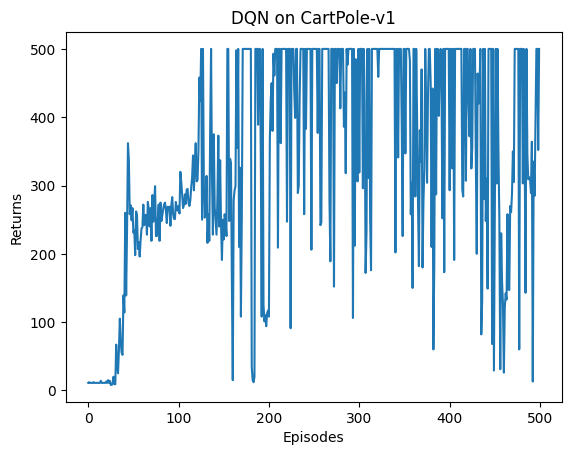

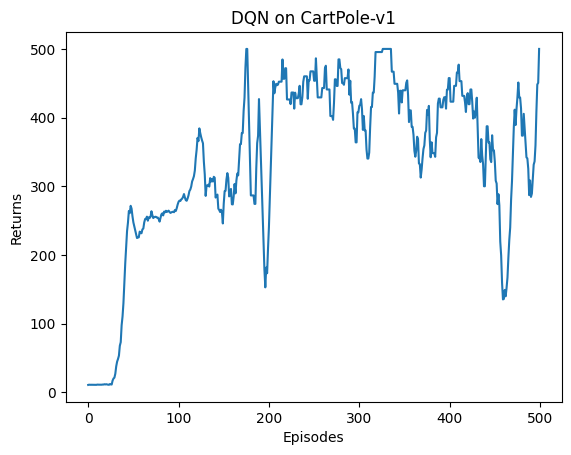

In [13]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

In [ ]:
class ConvolutionalQnet(torch.nn.Module):
    ''' 加入卷积层的Q网络 '''
    def __init__(self, action_dim, in_channels=4):
        super(ConvolutionalQnet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = torch.nn.Linear(7 * 7 * 64, 512)
        self.head = torch.nn.Linear(512, action_dim)

    def forward(self, x):
        x = x / 255
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x))
        return self.head(x)

### 尝试总结今天所学
1. 在状态和动作无限的情况下,Q-table无效,需要用神经网络拟合函数
2. 由于神经网络依赖独立同分布的数据, 我们需要储存一批之前用过的数据,然后随机采样,达成独立同分布的效果.
3. 由于mse_lose中参数是td_target,q(s,a),由于参数中包含优化目标,需要延迟更新参数中的优化目标来保证训练稳定
4. gym库进行了更新代码,需要一定程度上重新学习
5. 对于神经网络,要特别留意tensor的维度